# CartPole with DQN algorithm

Этот пример демонстрирует применение алгоритма DQN для задачи обучения агента на среде CartPole-v1 из пакета Gymnasium на базе PyTorch.
Original link: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#dqn-algorithm

## Задача

Агент должен принять решение между двумя действиями - перемещением тележки влево или вправо - так, чтобы прикрепленный к ней шест остался в вертикальном положении.

## Imports

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

from tqdm import tqdm

from IPython import display

Когда агент наблюдает за текущим состоянием среды и выбирает действие, среда переходит в новое состояние, а также возвращает вознаграждение, указывающее на последствия этого действия. В данной задаче награда равна +1 за каждый инкрементный временной шаг, и среда завершается, если шест падает слишком сильно в сторону или тележка удаляется от центра более чем на 2,4 единицы. Это означает, что сценарии с лучшими результатами будут выполняться дольше, накапливая большую награду.

Задача CartPole построена таким образом, что входными данными для агента являются 4 реальных значения, представляющие состояние среды (положение, скорость и т.д.). Мы берем эти 4 входных сигнала без какого-либо масштабирования и пропускаем их через небольшую полносвязную сеть с 2 выходами, по одному на каждое действие. Сеть обучается предсказывать ожидаемое значение для каждого действия с учетом входного состояния. Затем выбирается действие с наибольшим ожидаемым значением.

### Replay Memory

Для обучения DQN мы будем использовать Replay Memory. В этом буфере хранятся переходы, которые наблюдал агент, что позволяет нам использовать эти данные в дальнейшем. 
Мы собираем выборку из этого буфера случайным образом, что позволяет избежать корреляции между ними.
Это значительно стабилизирует и улучшает процедуру обучения DQN.

Для этого нам понадобятся два класса:

`Transition` - именованный кортеж, представляющий один переход в нашем окружении. По сути, он сопоставляет пары (состояние, действие) с их результатом (следующее_состояние, награда), причем состояние - это изображение разницы на экране.

`ReplayMemory` - циклический буфер ограниченного размера, в котором хранятся переходы, наблюдавшиеся в последнее время. В нем также реализован метод `.sample()` для выбора случайной выборки переходов для обучения.

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


Наша модель будет представлять собой нейронную сеть, которая учитывает разницу между текущим и предыдущим экранами. Она имеет два выхода, представляющих собой $Q(s,left)$ и $Q(s,right)$ (где $s$ - вход сети). По сути, сеть пытается предсказать ожидаемую прибыль от каждого действия с учетом текущих входных данных.

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = f.relu(self.layer1(x))
        x = f.relu(self.layer2(x))
        return self.layer3(x)

Класс агента - фактически весь алгоритм обучения реализован здесь.

`select_action` - выбор действия в соответствии с эпсилон-жадной политикой. Проще говоря, иногда мы будем использовать нашу модель для выбора действия, а иногда - просто равномерную выборку. Вероятность выбора случайного действия будет начинаться с `EPS_START` и экспоненциально убывать по направлению к `EPS_END`. `EPS_DECAY` управляет скоростью затухания.

`plot_durations` - помощник для построения графика продолжительности эпизодов, а также среднего значения за последние 100 эпизодов (показатель, используемый в оценках). График будет находиться под ячейкой, содержащей основной цикл обучения, и обновляться после каждого эпизода.

In [10]:
class DQNAgent(object):

    def __init__(self, env, BATCH_SIZE=128):
        self.env = env
        self.state, self.info = env.reset()
        self.batch = None
        self.transitions = None
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = 0.99
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 1000
        self.TAU = 0.005
        self.LR = 1e-4
        self.FULL_MEMORY_LENGTH = 10000
        self.episode_durations = []
        self.is_ipython = 'inline' in matplotlib.get_backend()
        self.n_actions = env.action_space.n
        self.n_observations = len(self.state)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(self.n_observations, self.n_actions).to(self.device)
        self.target_net = DQN(self.n_observations, self.n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.memory = ReplayMemory(self.FULL_MEMORY_LENGTH)
        self.steps_done = 0

    def plot_durations(self, show_result=False, is_ipython=True):
        """
        A helper for plotting the duration of episodes, along with an average over the last 100 episodes 
        (the measure used in the evaluations). 
        The plot will be underneath the cell containing the main training loop, and will update after every episode.
        @param: show_result
        @param: is_ipython
        """
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def select_action(self, state, env=None):
        """
        выбор действия в соответствии с эпсилон-жадной политикой. 
        Иногда мы будем использовать нашу модель для выбора действия, а иногда - просто равномерную выборку. Вероятность выбора случайного действия будет начинаться с `EPS_START` и экспоненциально убывать по направлению к `EPS_END`. `EPS_DECAY` управляет скоростью затухания."""
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
                        math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        self.transitions = self.memory.sample(self.BATCH_SIZE)
        # This converts batch-array of Transitions
        # to Transition of batch-arrays.
        self.batch = Transition(*zip(*self.transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        self.non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                self.batch.next_state)), device=self.device, dtype=torch.bool)
        self.non_final_next_states = torch.cat([s for s in self.batch.next_state
                                           if s is not None])
        self.state_batch = torch.cat(self.batch.state)
        self.action_batch = torch.cat(self.batch.action)
        self.reward_batch = torch.cat(self.batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        self.state_action_values = self.policy_net(self.state_batch).gather(1, self.action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        self.next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
        with torch.no_grad():
            self.next_state_values[self.non_final_mask] = self.target_net(self.non_final_next_states).max(1)[0]
        # Compute the expected Q values
        self.expected_state_action_values = (self.next_state_values * self.GAMMA) + self.reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(self.state_action_values, self.expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def train(self):
        if torch.cuda.is_available():
            num_episodes = 1500
        else:
            num_episodes = 600

        for i_episode in tqdm(range(num_episodes)):
            # Initialize the environment and get it's state
            self.state, self.info = self.env.reset()
            self.state = torch.tensor(self.state, dtype=torch.float32, device=self.device).unsqueeze(0)
            for t in count():
                self.action = self.select_action(self.state)
                self.observation, self.reward, self.terminated, self.truncated, _ = self.env.step(self.action.item())
                self.reward = torch.tensor([self.reward], device=self.device)
                self.done = self.terminated or self.truncated

                if self.terminated:
                    self.next_state = None
                else:
                    self.next_state = torch.tensor(self.observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store the transition in memory
                self.memory.push(self.state, self.action, self.next_state, self.reward)

                # Move to the next state
                self.state = self.next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                self.target_net_state_dict = self.target_net.state_dict()
                self.policy_net_state_dict = self.policy_net.state_dict()
                for key in self.policy_net_state_dict:
                    self.target_net_state_dict[key] = self.policy_net_state_dict[key] * self.TAU + self.target_net_state_dict[key] * (
                            1 - self.TAU)
                self.target_net.load_state_dict(self.target_net_state_dict)

                if self.done:
                    self.episode_durations.append(t + 1)
                    # self.plot_durations()
                    break

        print('Complete')
        self.plot_durations(show_result=True)
        plt.ioff()
        plt.show()

100%|██████████| 600/600 [01:31<00:00,  6.55it/s]


Complete


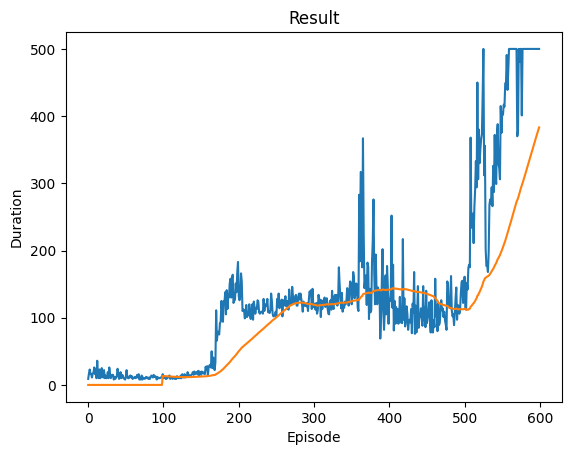

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
env = gym.make("CartPole-v1")
agent_128 = DQNAgent(env, BATCH_SIZE=128)
agent_128.train()

Complete


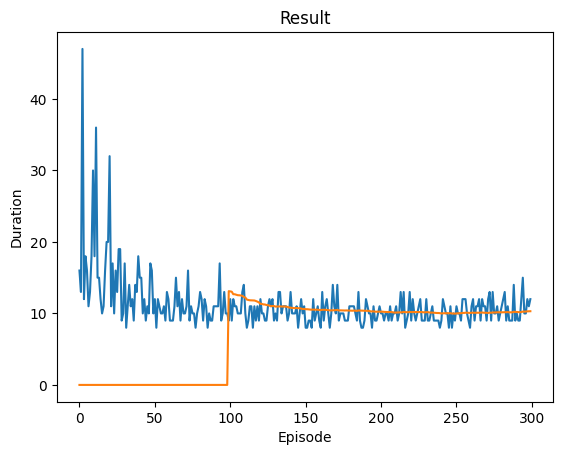

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
agent_5 = DQNAgent(env, BATCH_SIZE=5)
agent_5.train()